In [1]:


import os


# define cache for sentencebert
os.environ['XDG_CACHE_HOME'] = 'home/msds2022/plarosa/ .cache'

import time
import re
import string
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

import torch
from sentence_transformers import SentenceTransformer, util
import umap.umap_ as umap

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

import nlpaug
import nlpaug.augmenter.word as naw

from automl_prec import AutoML


### Extract Data

In [5]:
df = pd.read_csv('../data/abstract_topic.csv')
display(df.head())

,index,Doc,Topic,Topic Name
0,0,the ched phernet-admu program has been conduct...,-1,Outliers
1,1,the warm tropical climate of the philippines a...,5,CROP CULTIVATION
2,2,the study was conducted to determine the green...,1,EDUCATION
3,3,this study aimed to establish a solid waste ma...,8,GOVERNANCE / POLICY
4,4,farming systems refers to the utilization of t...,5,CROP CULTIVATION


In [37]:
import pickle
import os
def dump(fname, data):
    if fname in os.listdir('./plots/fig_data/'):
        raise Exception('Duplicate filename: change fname')
    
    with open(f'plots/fig_data/{fname}', 'wb') as f:
        pickle.dump(data, f)

In [38]:
dump('df_topic_clf2.pickle', 'df_topic_clf.pickle')

### EDA

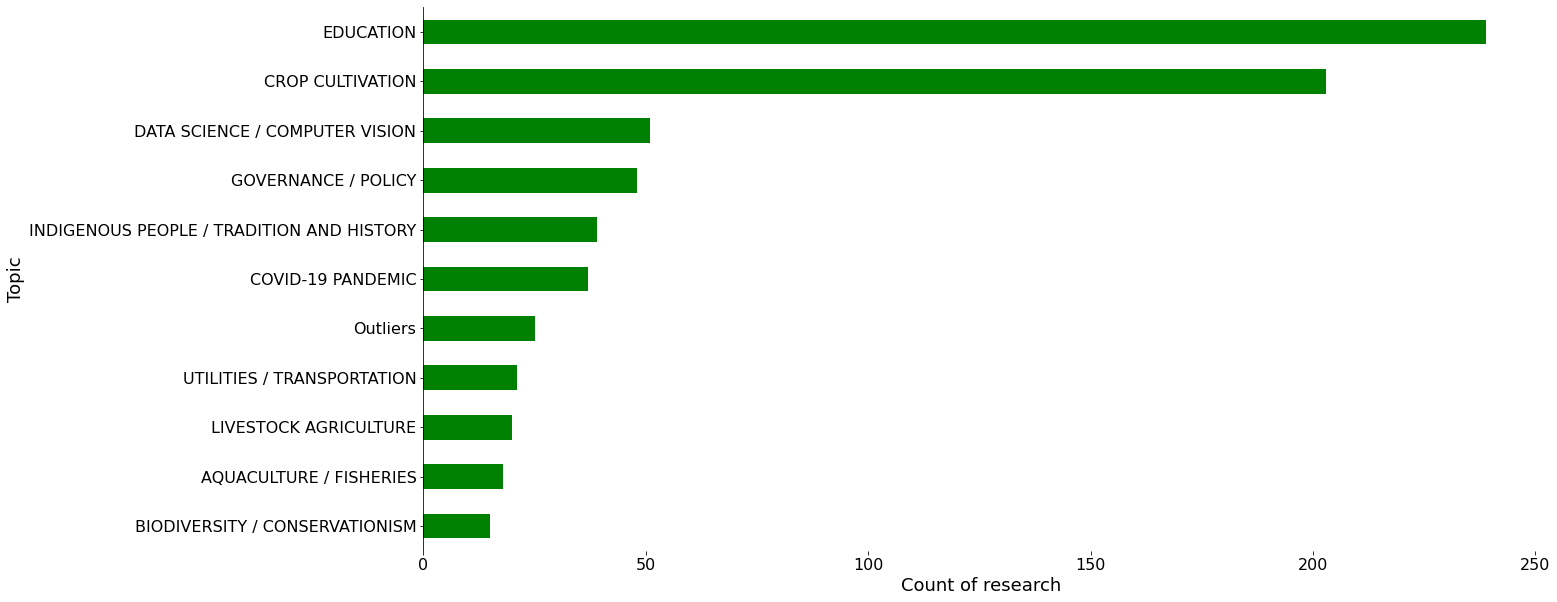

In [12]:
df['Topic Name'].value_counts()[::-1].plot.barh(figsize=(20,10), color='green')
ax = plt.gca()
plt.xticks(rotation = 0)
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.gca().spines.bottom.set_visible(False)
plt.ylabel('Topic', fontsize=18)
plt.xlabel('Count of research', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16);

In [15]:
df

,index,Doc,Topic,Topic Name
0,0,the ched phernet-admu program has been conduct...,-1,Outliers
1,1,the warm tropical climate of the philippines a...,5,CROP CULTIVATION
2,2,the study was conducted to determine the green...,1,EDUCATION
3,3,this study aimed to establish a solid waste ma...,8,GOVERNANCE / POLICY
4,4,farming systems refers to the utilization of t...,5,CROP CULTIVATION
...,...,...,...,...
711,1258,sustainable and profitable management of falca...,5,CROP CULTIVATION
712,1260,recently diverse innovative processes in food ...,5,CROP CULTIVATION
713,1261,ensuring proper health and nutrition of the pe...,5,CROP CULTIVATION
714,1262,this project aims to facilitate the delivery o...,5,CROP CULTIVATION


Note:
- Highly imbalanced dataset

### Preprocess

In [16]:
# casefold abstract - because pretrained is uncased
# remove punctuations - does not add any meaning
df['Doc'] = (df.Doc.str.lower()
                        .str.replace('“', '', regex=False)
                        .str.replace(':', '', regex=False)
                        .str.replace('(', '', regex=False)
                        .str.replace(')', '', regex=False))

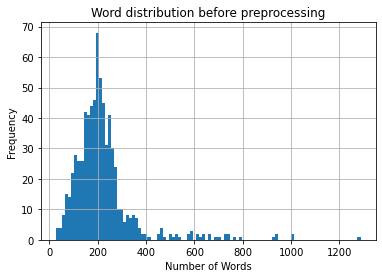

In [17]:
df.Doc.str.split(' ').apply(lambda x: len(x)).hist(bins=100)
plt.title('Word distribution before preprocessing')
plt.xlabel('Number of Words')
plt.ylabel('Frequency');

In [18]:
# load sentence transformer model
# model = SentenceTransformer('allenai/scibert_scivocab_uncased')
model = SentenceTransformer('allenai/specter')
model.max_seq_length = 512

In [19]:
# encode abstract using pretrained model
start_time = time.time()
embeddings = model.encode(df.Doc.tolist(), convert_to_tensor=True)
end_time = time.time()
print("Time for computing embeddings:", str(end_time - start_time))

Time for computing embeddings: 7.526733636856079


### Model Training 

#### Baseline Models

In [20]:
X = pd.DataFrame(embeddings.cpu().numpy())
y = df.reset_index(drop=True)['Topic']

# le = LabelEncoder()
# y = le.fit_transform(y)


In [13]:
counts = pd.Series(y).value_counts()
pcc = (counts / counts.sum()) ** 2
pcc = pcc.sum() * 1.25
print("Proportional Chance Criterion (PCC): ", pcc)

Proportional Chance Criterion (PCC):  0.2636758372085765


knn Classification: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]


,Machine Learning Method,Test Precision,Best Parameter,Top Predictor Variable,Run Time
0,Decision Tree,0.505905,max_depth = 10,349,22.416367
1,Random Forest,0.666813,max_depth = 10,747,32.439209
2,Logistic Regression (l1),0.838267,C = 1000,726,82.437485
3,Linear SVM (l1),0.823930,C = 10,373,487.285070
4,Logistic Regression (l2),0.849968,C = 10000,454,359.723707
5,Linear SVM (l2),0.851489,C = 0.1,168,139.512672
716,knn Classification,0.862771,n_neighbors = 1,NA,8.445334


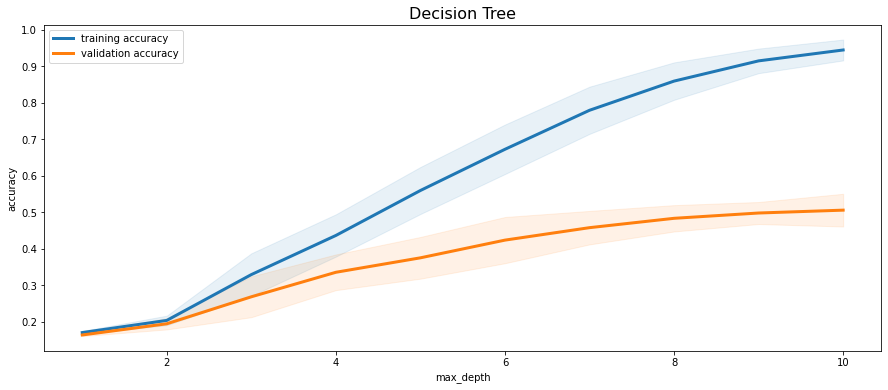

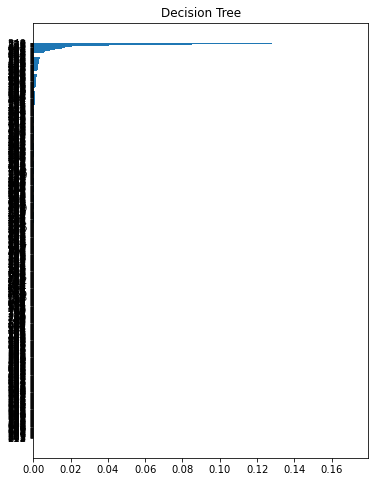

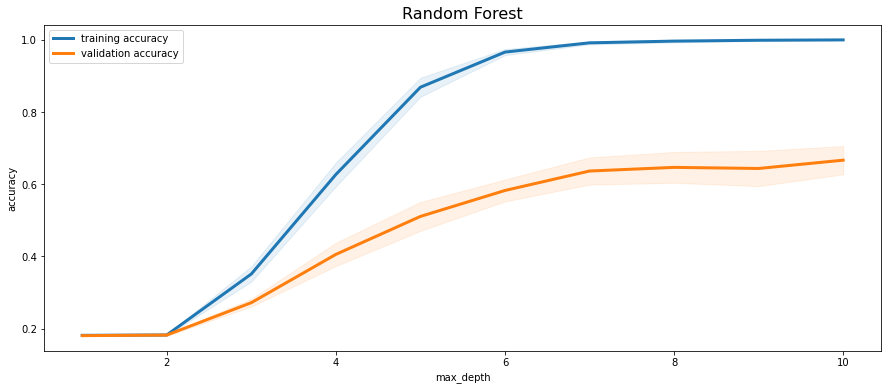

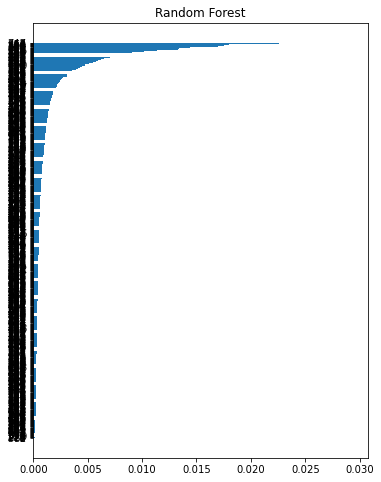

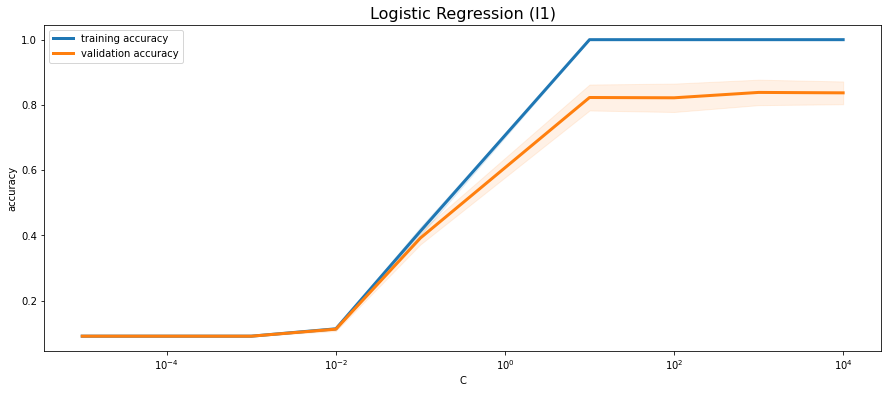

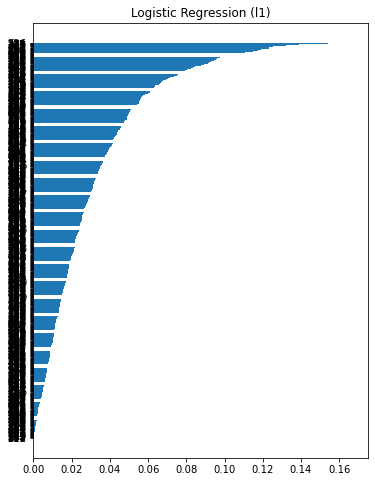

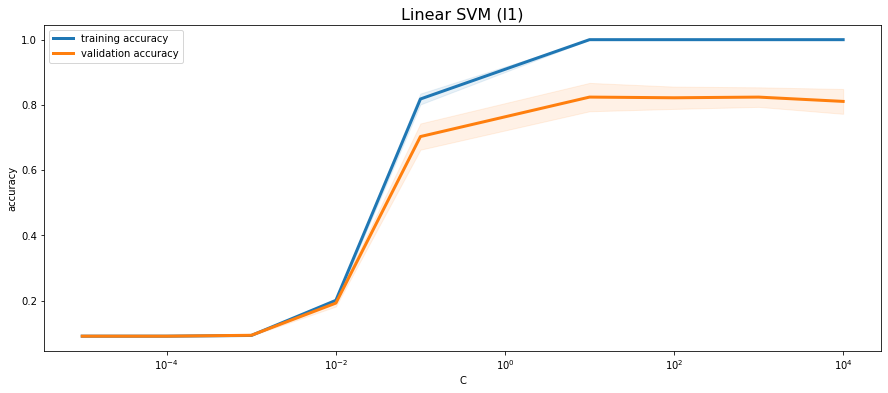

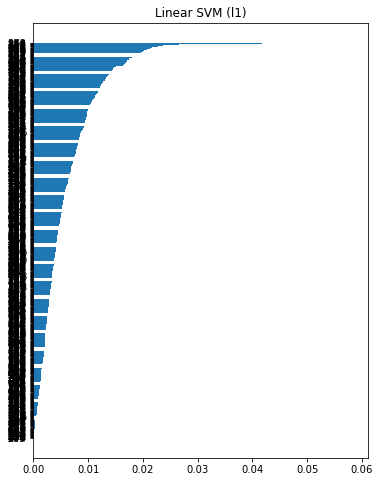

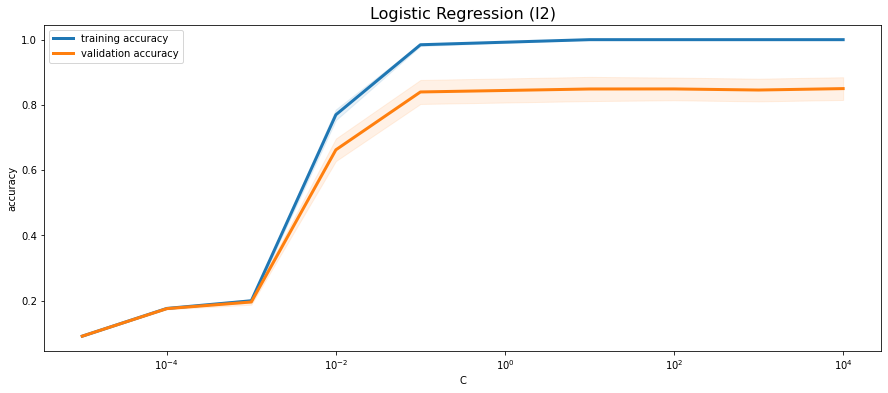

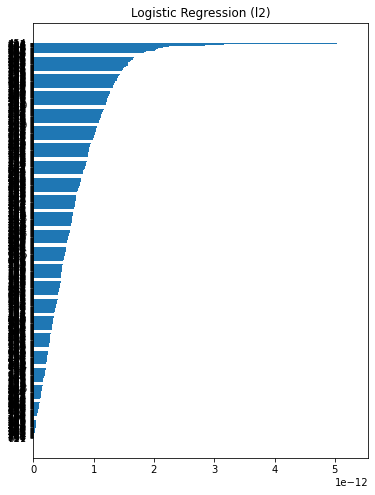

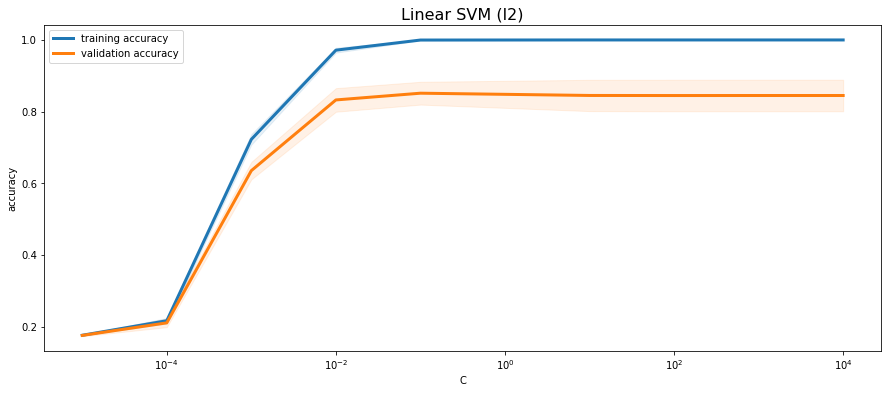

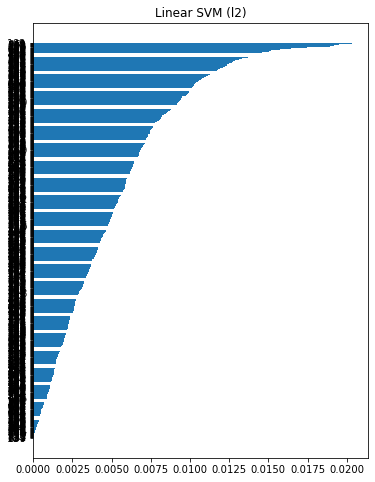

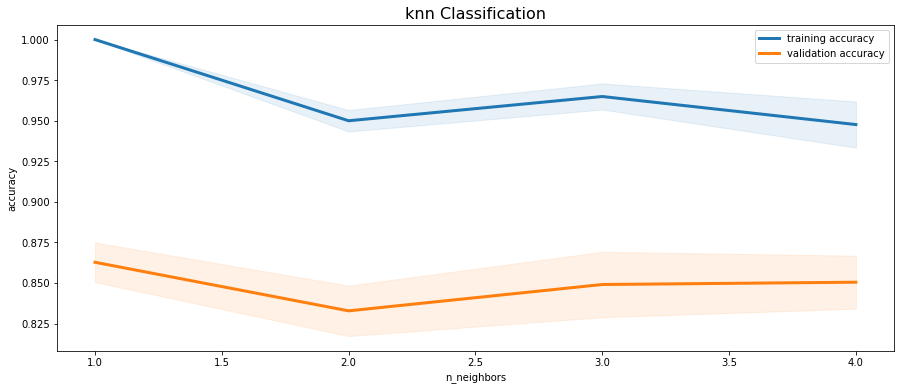

In [14]:
C = [1e-5, 1e-4, 1e-3, .01, 0.1, 10, 100, 1000, 10000]
n_neighbors = list(range(1, 51))
max_depth = list(range(1, 11))

automl_tree = AutoML(['dtc', 'rfc'])
splits = automl_tree.split_data(X, y, shuffle=True, 
                                num_trials=10, stratify=True, 
                                test_size=0.25)
automl_tree.train_model(X, y, 
                        param_grid={'max_depth':max_depth})
tree_summary = automl_tree.generate_summary()

automl_linear_l1 = AutoML(['log', 'svl'])
splits = automl_linear_l1.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True,
                                     test_size=0.25)
automl_linear_l1.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l1'})
linearl1_summary = automl_linear_l1.generate_summary()

automl_linear_l2 = AutoML(['log', 'svl'])
splits = automl_linear_l2.split_data(X, y, shuffle=True, 
                                     num_trials=20, stratify=True, 
                                     test_size=0.25)
automl_linear_l2.train_model(X, y, param_grid= {'C' : C}, 
                        fixed_params={'penalty' : 'l2'})
linearl2_summary = automl_linear_l2.generate_summary()

automl_knc = AutoML('knc')
splits = automl_knc.split_data(X, y, num_trials=5, stratify=True, 
                               test_size=0.25, 
                               shuffle=True)
automl_knc.train_model(X, y, param_grid={'n_neighbors' : range(1,5)})
knc_summary = automl_knc.generate_summary()


df1 = pd.concat([tree_summary, 
                linearl1_summary, 
                linearl2_summary]).reset_index(drop=True)
knc_summary = pd.Series(knc_summary, index=df1.columns)
df1.loc[len(df)] = knc_summary
display(df1)

Notes:
- Models took time to train
- Mostly overfitting

### Evaluation

In [21]:
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y,
                                    test_size=0.25,
                                    random_state=143, 
                                    shuffle=True,
                                    stratify=y)

model = LinearSVC(C=0.1)
model.fit(X_train, y_train);

In [27]:
with open('clf_report_topic.pickle', 'wb') as f:
    pickle.dump(clf_report, f)

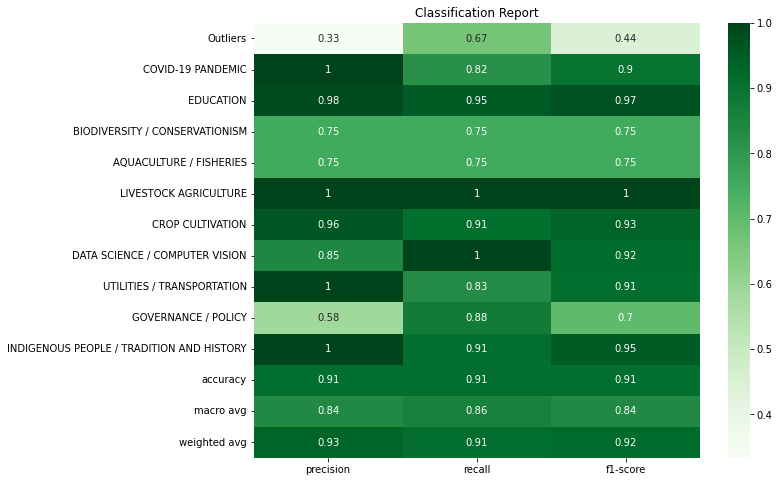

In [22]:
topic_mapping = (df[['Topic', 'Topic Name']].drop_duplicates()
                  .set_index('Topic').to_dict()['Topic Name'])

plt.figure(figsize=(10, 8))
clf_report = classification_report(model.predict(X_test), 
                                   y_test,
                                   output_dict=True, 
                                   zero_division=0)

clf_report_df = pd.DataFrame(clf_report).iloc[:-1, :].T
clf_report_df.index = [topic_mapping[int(col)] 
                       if col not in ['accuracy', 'macro avg', 'weighted avg'] 
                       else col for col in clf_report_df.index]

sns.heatmap(clf_report_df, annot=True, cmap='Greens')
;

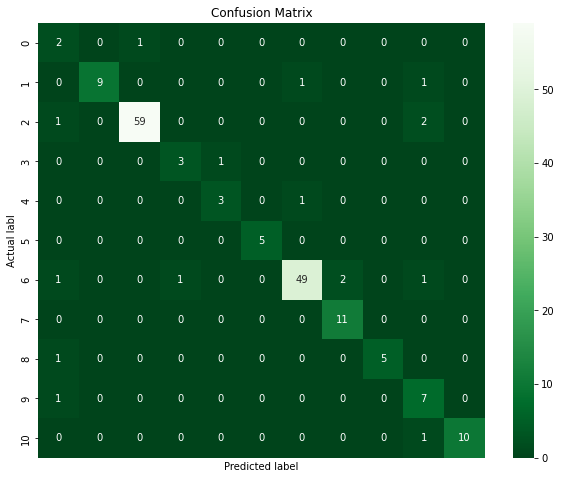

In [26]:
plt.figure(figsize=(10, 8))
cf_matrix = confusion_matrix(model.predict(X_test), y_test,
                            )

cf_df = pd.DataFrame(cf_matrix)
# cf_df.columns = [topic_mapping[col - 1] for col in cf_df.columns]
# cf_df.index = [topic_mapping[col - 1] for col in cf_df.index]


sns.heatmap(cf_df, annot=True, cmap='Greens_r')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('Actual labl')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

In [43]:
cf_df

,0,1,2,3,4,5,6,7,8,9,10
0,2,0,0,0,0,0,0,0,1,0,0
1,0,9,0,0,0,0,0,0,0,0,0
2,2,0,60,0,0,0,0,0,1,1,0
3,0,0,0,3,0,0,0,0,0,0,0
4,0,0,0,0,3,0,0,0,0,0,0
5,0,0,0,0,0,5,0,0,0,0,0
6,1,0,0,1,0,0,51,1,0,0,0
7,0,0,0,0,1,0,0,12,0,0,0
8,0,0,0,0,0,0,0,0,3,0,0
9,1,0,0,0,0,0,0,0,0,10,0


In [39]:
df[['Topic', 'Topic Name']].drop_duplicates().set_index('Topic').to_dict()['Topic Name']

{-1: 'Outliers',
 5: 'CROP CULTIVATION',
 1: 'EDUCATION',
 8: 'GOVERNANCE / POLICY',
 6: 'DATA SCIENCE / COMPUTER VISION',
 4: 'LIVESTOCK AGRICULTURE',
 9: 'INDIGENOUS PEOPLE / TRADITION AND HISTORY',
 7: 'UTILITIES / TRANSPORTATION',
 2: 'BIODIVERSITY / CONSERVATIONISM',
 0: 'COVID-19 PANDEMIC',
 3: 'AQUACULTURE / FISHERIES'}